In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sourcesep.models.nmf_variants import set_norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


def gaussfn(x, mu, sig): return 1/(np.sqrt(2*np.pi)*sig) * \
    np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

a_col = gaussfn(np.arange(200), mu=20, sig=10)
b_col = gaussfn(np.arange(200), mu=80, sig=10)

a_col_ = np.concatenate([a_col, 2*a_col])
a_col_ = set_norm(a_col_.reshape(-1,1), axis=0, c=1)[0]

b_col_ = np.concatenate([b_col, 3*b_col])
b_col_ = set_norm(b_col_.reshape(-1,1), axis=0, c=1)[0]

A = np.concatenate([a_col_,b_col_], axis=1)
H = np.abs(np.random.rand(2, 100))
X = A@H

print(f'A {A.shape}')
print(f'H {H.shape}')
print(f'X {X.shape}')

a_coeff = torch.tensor([1,0.5], requires_grad=True, dtype=torch.float32)
b_coeff = torch.tensor([1.,1.], requires_grad=True, dtype=torch.float32)
a_init = torch.tensor(np.abs(a_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)
b_init = torch.tensor(np.abs(b_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)
H_init = torch.tensor(np.abs(np.random.rand(2, 100)), requires_grad=True, dtype=torch.float32)

print(f'H {H_init.shape}')

A (400, 2)
H (2, 100)
X (400, 100)
H torch.Size([2, 100])


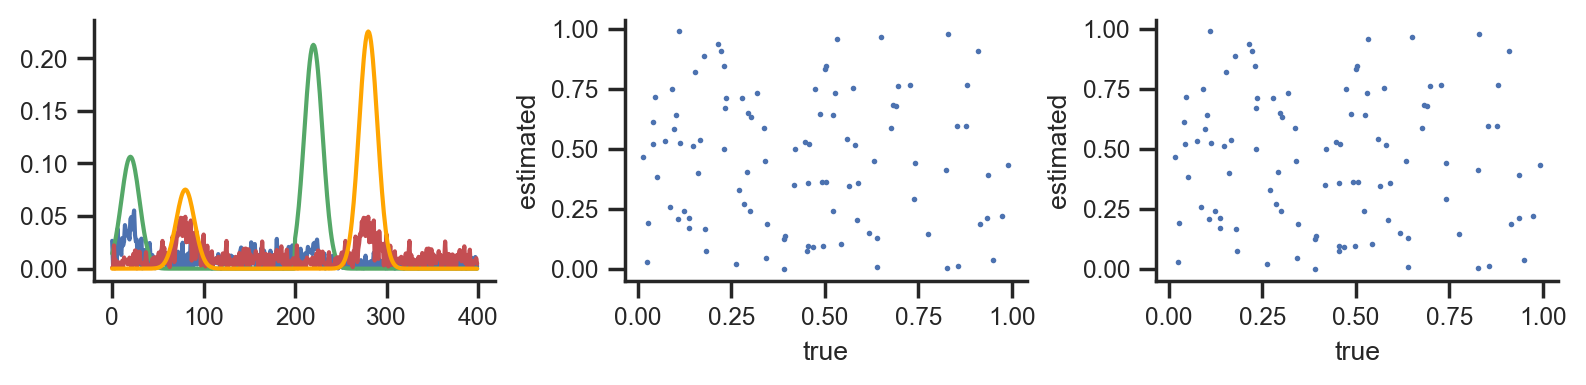

Loss: 6.444321155548096


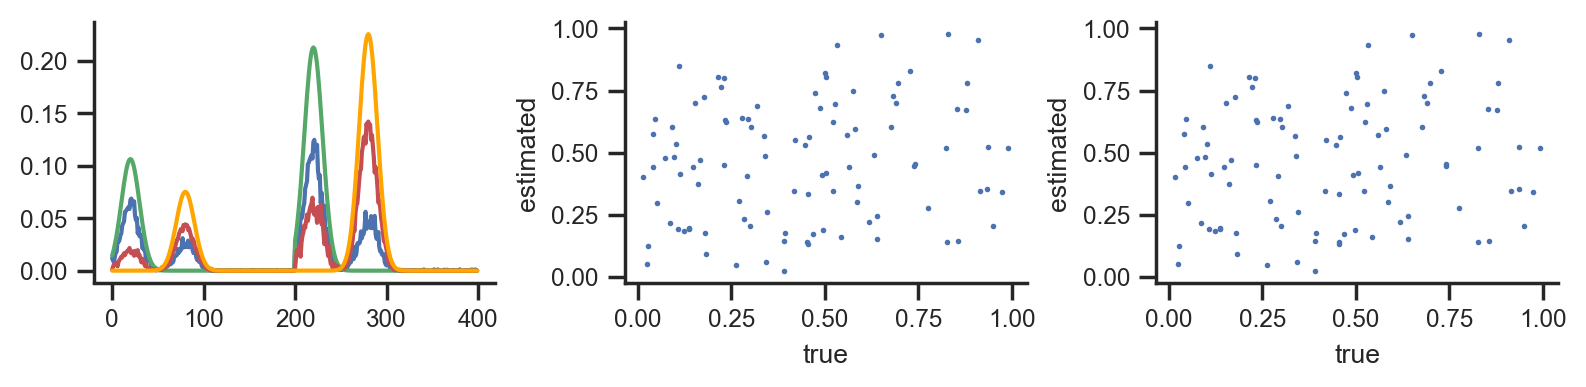

Loss: 4.110426902770996


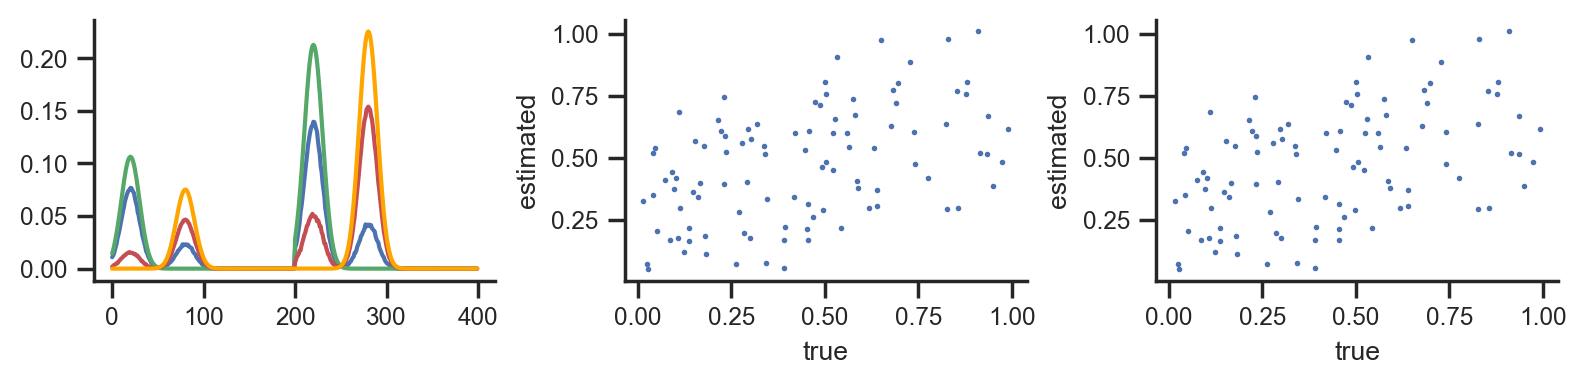

Loss: 3.36948561668396


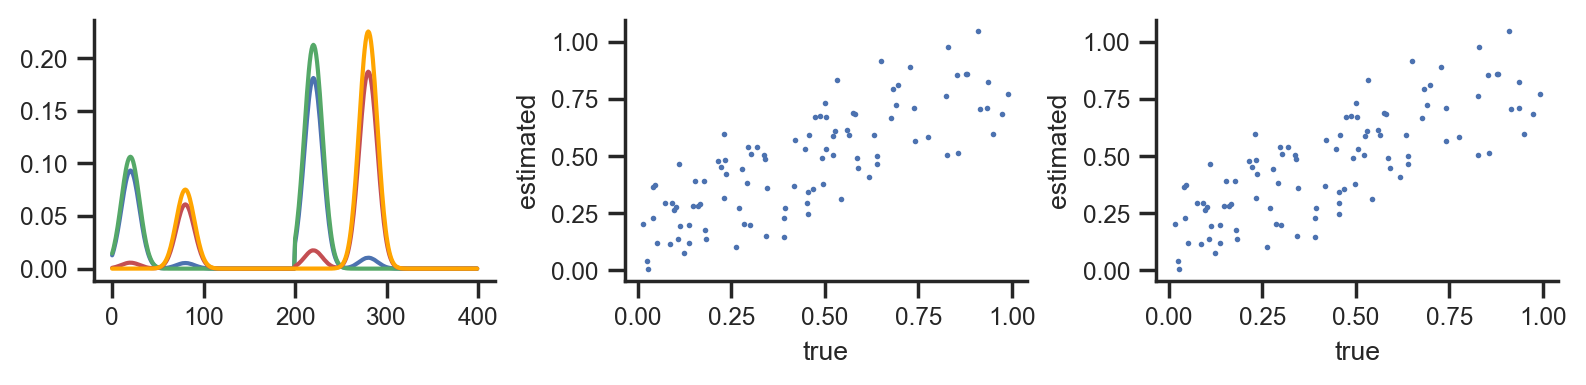

Loss: 2.330470561981201


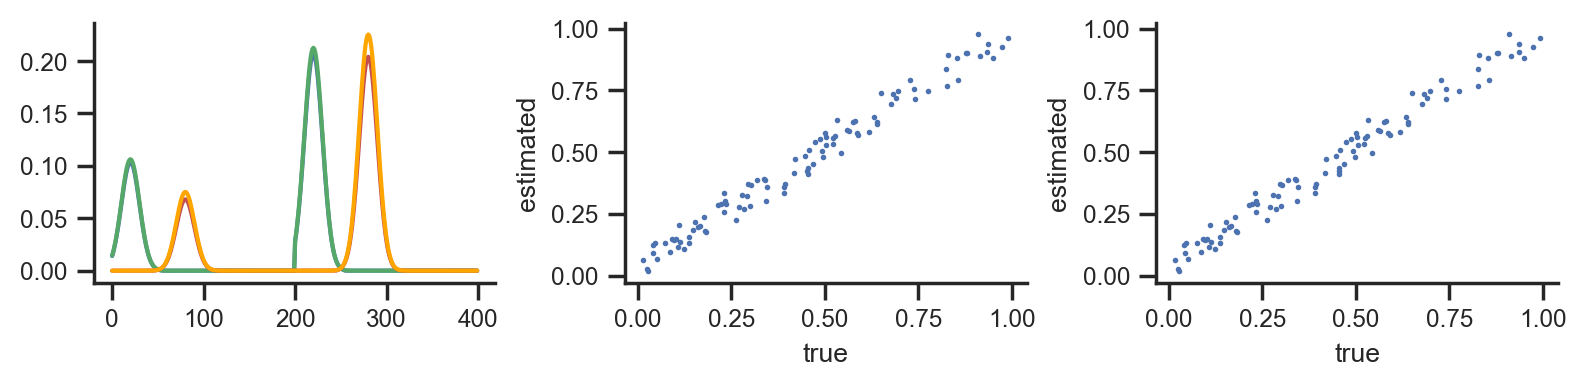

Loss: 0.670626699924469


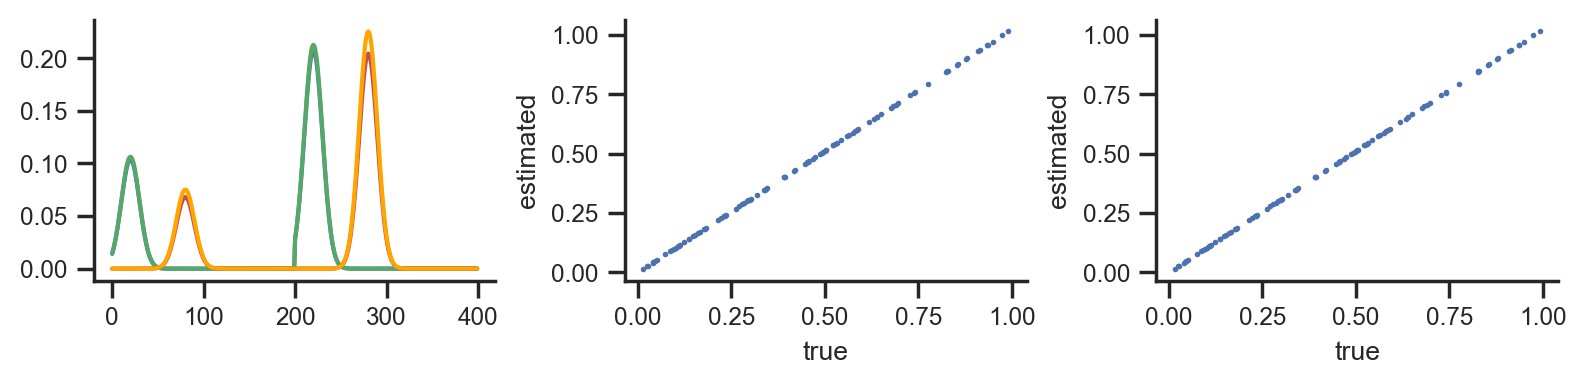

Loss: 0.02476394549012184


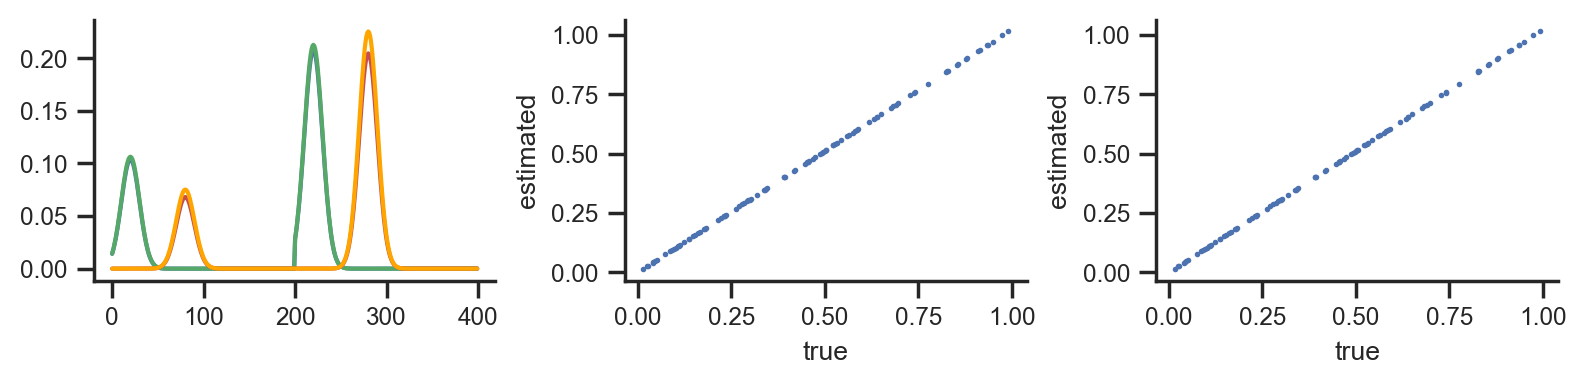

Loss: 0.024883855134248734


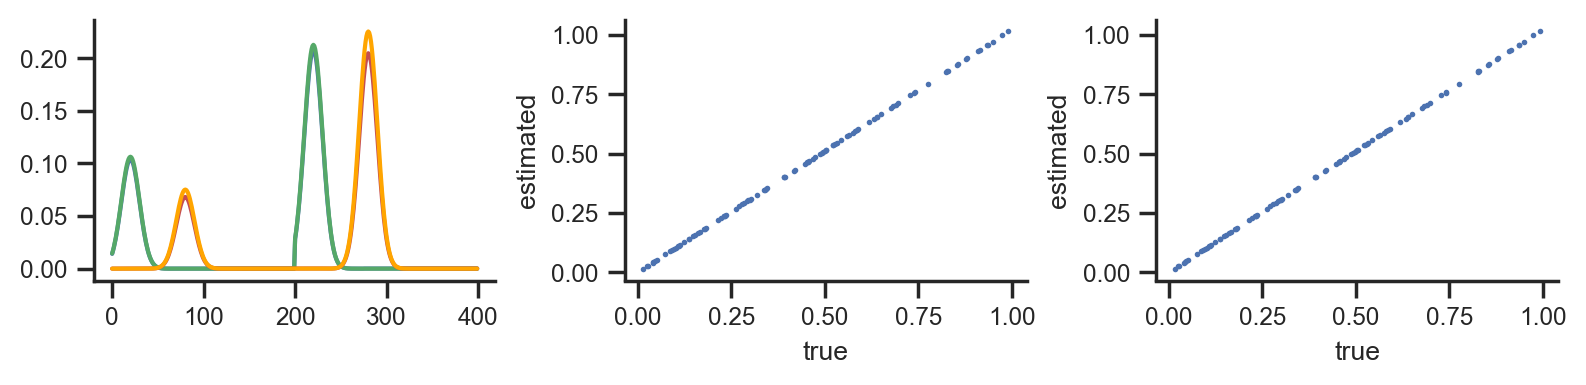

Loss: 0.023512518033385277


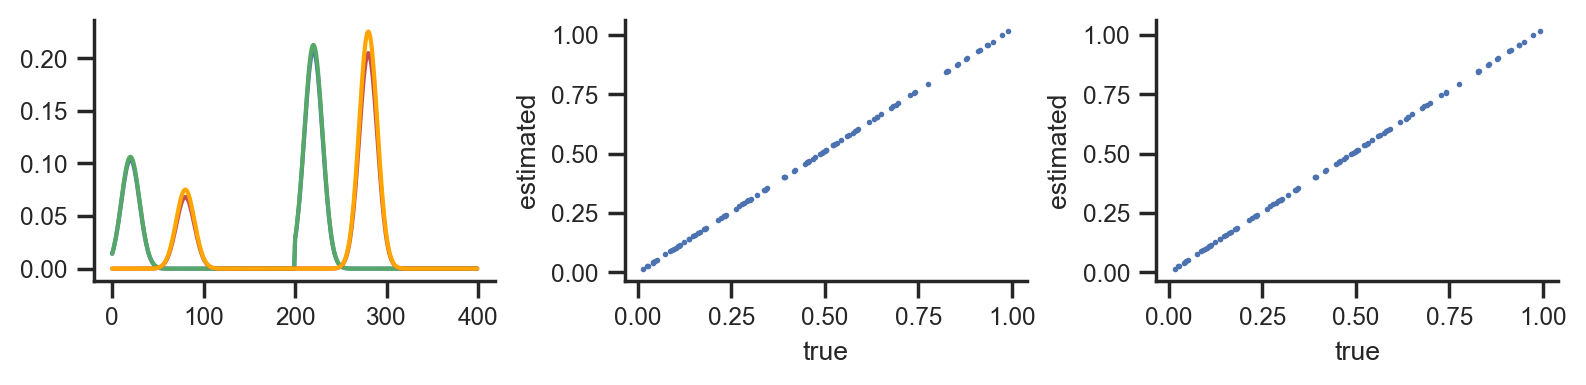

Loss: 0.02430923655629158


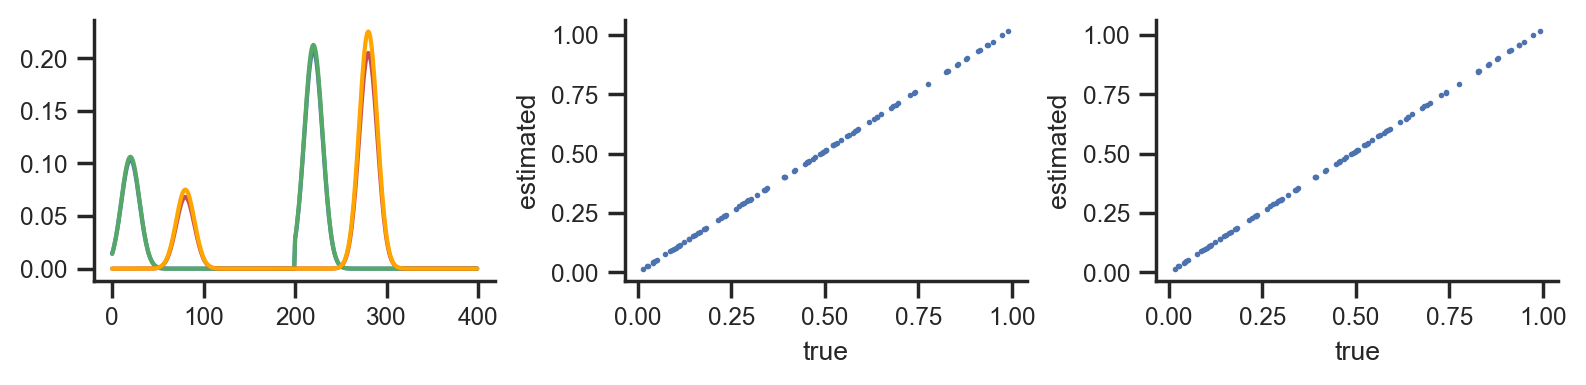

Loss: 0.024800486862659454


In [2]:
# Set learning rate
lr = .001

prox_plus = torch.nn.Threshold(0,1e-4)
prox_softplus = torch.nn.Softplus()
def prox_norm(x):
    return x / torch.norm(x, p=2)

for i in range(20000):
    #Concatenate the two tensors to create the input matrix
    #A_init = torch.cat((a_init.repeat(1, 2), b_init.repeat(1, 2)), 0).T
    a_init_ = torch.cat((a_coeff[0]*a_init, a_coeff[1]*a_init), axis=0)
    b_init_ = torch.cat((b_coeff[0]*b_init, b_coeff[1]*b_init), axis=0)
    A_init = torch.stack((a_init_, b_init_), axis=0).T
    X_ = torch.matmul(A_init, H_init)
    dmat = X_ - torch.as_tensor(X, dtype=torch.float32)
    loss = torch.linalg.matrix_norm(dmat, ord='fro')
    loss.backward(retain_graph=True) 

    with torch.no_grad():
        for p in [a_init, b_init, H_init, a_coeff, b_coeff]:
            p -= lr * p.grad
            p.data = prox_plus(p)
            p.grad.zero_()

        for p in [a_init, b_init]:
            p.data = prox_norm(p)            

    if i%2000==0:
        f, ax = plt.subplots(1, 3, figsize=(8,2))
        ax[0].plot(a_init_.detach().numpy(), c='b')
        ax[0].plot(a_col_, c='g')
        ax[0].plot(b_init_.detach().numpy(), c='r')
        ax[0].plot(b_col_, c='orange')
        
        ax[1].scatter(H[0, :], H_init[0, :].detach().numpy(), s=1)
        ax[1].set(xlabel='true', ylabel='estimated')

        ax[2].scatter(H[0, :], H_init[0, :].detach().numpy(), s=1)
        ax[2].set(xlabel='true', ylabel='estimated')
        plt.tight_layout()
        plt.show()

        print(f'Loss: {loss.item()}')